<a href="https://colab.research.google.com/github/goldenspring6622/CS114.M21.N02/blob/main/Toxic_Comment_Detection_On_Youtube_Football_Livestream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT PACKAGES

In [24]:
! pip install openpyxl
#Documentation : https://openpyxl.readthedocs.io/en/stable/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
!pip3 install  xlrd==1.2.0
!pip install --upgrade pandas
!pip install underthesea
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from pandas import Series, DataFrame
import xlrd
from sklearn.feature_extraction.text import TfidfVectorizer
from xlrd import open_workbook
from underthesea import word_tokenize #Documentation :https://pypi.org/project/underthesea/ 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Preprocess

In [27]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.

In [28]:
dataTrainUIT = open_workbook("/content/dataset_main.xlsx", encoding_override='latin')
df = pd.read_excel(dataTrainUIT)


In [29]:
df.head()

,Content,Final
0,VN cố lên nha,0
1,90 phút nữa,0
2,các cầu thủ hãy cố gắng da hết mình nhé . nhất...,0
3,nhật ăn 3:0 r,0
4,1-0 cho vn,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Toxic Comment of Dataset')

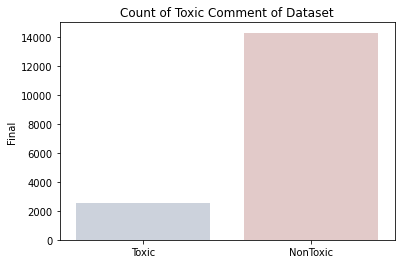

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(['Toxic', 'NonToxic'], df['Final'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(ascending=True), alpha=0.8,palette="vlag")

plt.title('Count of Toxic Comment of Dataset')

In [31]:
from tensorflow.keras.layers import TextVectorization

In [32]:
X = df['Content']
y = df['Final']
WordSeg = []
for i in range(len(X)):
        sentence_strip = str(X[i]).strip()# Remove spaces at begin & end
        WordSeg.append(word_tokenize(sentence_strip, format='text')) # format text: add "_" where text is phrases.
X = pd.DataFrame(WordSeg) # Update new sentences
print(X)

                                                       0
0                                          VN cố lên nha
1                                            90 phút nữa
2      các cầu_thủ hãy cố_gắng da hết_mình nhé . nhất...
3                                        nhật ăn 3 : 0 r
4                                             1-0 cho vn
...                                                  ...
16798                                    đá vẫn chán lắm
16799                            vaooooooooooooooooooooo
16800                                           yeahhhhh
16801                     ghi_bàn rồi sẽ giải_toả tâm_lí
16802                      SUIIIIIIIIIIIIIIIIIIIIIIIIIII

[16803 rows x 1 columns]


In [33]:
MAX_FEATURES = 200000 # number of words in the vocab

In [34]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=50,
                               output_mode='int')

In [35]:
vectorizer.adapt(X.values)

In [36]:
vectorized_text = vectorizer(X.values)

In [37]:
print(vectorized_text)

tf.Tensor(
[[   3   29   16 ...    0    0    0]
 [ 831  141   65 ...    0    0    0]
 [  64  142  584 ...    0    0    0]
 ...
 [4703    0    0 ...    0    0    0]
 [ 241    8  152 ...    0    0    0]
 [5847    0    0 ...    0    0    0]], shape=(16803, 50), dtype=int64)


In [38]:
print(vectorized_text)

tf.Tensor(
[[   3   29   16 ...    0    0    0]
 [ 831  141   65 ...    0    0    0]
 [  64  142  584 ...    0    0    0]
 ...
 [4703    0    0 ...    0    0    0]
 [ 241    8  152 ...    0    0    0]
 [5847    0    0 ...    0    0    0]], shape=(16803, 50), dtype=int64)


In [39]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [40]:
train = dataset.take(int(len(dataset)*.6))#Train set 60%
val = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.2))#Valuating set 20%
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))#Test set 20%

# 2. Create Sequential Model

Mạng này sẽ nhận vào input là X và trả ra output Y : 
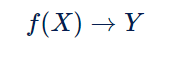

In [41]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

Sigmoid Function : 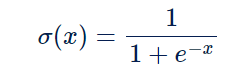

Hàm Sigmoid nhận đầu vào là một số thực và chuyển thành một giá trị trong khoảng (0;1) (xem đồ thị phía trên). Đầu vào là số thực âm rất nhỏ sẽ cho đầu ra tiệm cận với 0, ngược lại, nếu đầu vào là một số thực dương lớn sẽ cho đầu ra là một số tiệm cận với 1.

tanH Function : 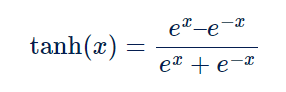

Hàm  nhận đầu vào là một số thực và chuyển thành một giá trị trong khoảng (-1; 1). Cũng như Sigmoid, hàm Tanh bị bão hoà ở 2 đầu (gradient thay đổi rất ít ở 2 đầu).

reLU Function : 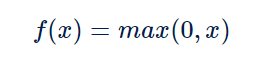

 ReLU đơn giản lọc các giá trị < 0.



In [42]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

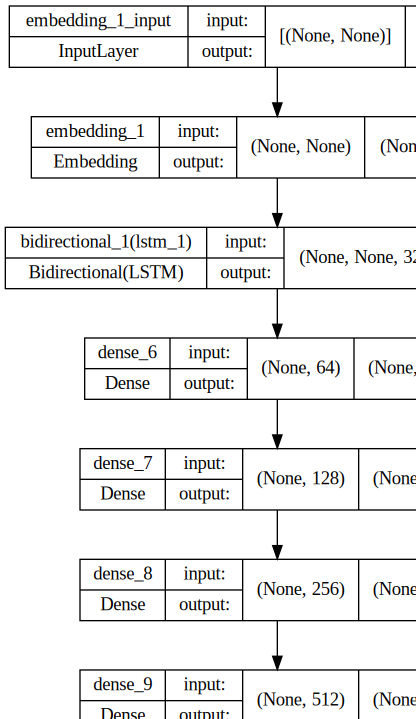

In [43]:
import keras
%matplotlib inline 

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model.png')

# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.

Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.
Về mặt toán học, nếu như MSE tính khoảng cách giữa 2 đại lượng số thì cross-entropy hiểu nôm na là phương pháp tính khoảng cách giữa 2 phân bố xác suất.
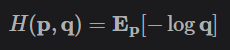

Với p và q là rời rạc (như y - nhãn thật sự và y^ - nhãn dự đoán ) trong bài toán của chúng ta), công thức này được viết dưới dạng:

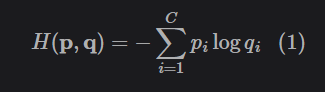

Trong đó C là số lượng các class cần phân lớp, trong bài toán binary classification thì C = 2.

Hàm mất mát: Binary Cross Entropy tính toán độ chênh lệch giữa 2 phân phối xác suất của dự đoán và của nhãn. Đầu ra của mô hình là phân phối xác suất (p, 1 - p) biểu diễn xác suất xảy ra của một trong hai nhãn. Phân phối xác suất của nhãn có dạng (y, 1 - y) với y nhận giá trị 0 hoặc 1.

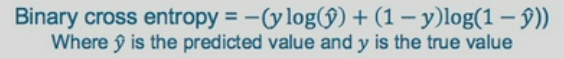

In [44]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

In [46]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
630/630 [==============================] - 86s 127ms/step - loss: 0.2950 - val_loss: 0.1630
Epoch 2/15
630/630 [==============================] - 69s 109ms/step - loss: 0.1584 - val_loss: 0.1157
Epoch 3/15
630/630 [==============================] - 70s 110ms/step - loss: 0.1165 - val_loss: 0.0865
Epoch 4/15
630/630 [==============================] - 71s 112ms/step - loss: 0.0918 - val_loss: 0.0711
Epoch 5/15
630/630 [==============================] - 72s 114ms/step - loss: 0.0791 - val_loss: 0.0653
Epoch 6/15
630/630 [==============================] - 87s 139ms/step - loss: 0.0763 - val_loss: 0.0497
Epoch 7/15
630/630 [==============================] - 79s 125ms/step - loss: 0.0574 - val_loss: 0.0420
Epoch 8/15
630/630 [==============================] - 67s 107ms/step - loss: 0.0521 - val_loss: 0.0491
Epoch 9/15
630/630 [==============================] - 72s 115ms/step - loss: 0.0481 - val_loss: 0.0455
Epoch 10/15
630/630 [==============================] - 71s 112ms/step - l

In [47]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

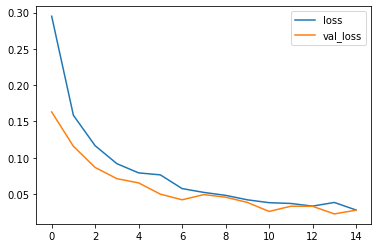

In [48]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [49]:
input_text = vectorizer(['tụi m giỏi thì vào mà đá, ở đó mà sủa ngu'])

In [50]:
print(input_text)

tf.Tensor(
[[295 117 247  14  17  11   2 149 122  11 849 112   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [51]:
res = model.predict(input_text)

In [52]:
print(res)

[[0.6415643]]


In [53]:
(res > 0.5).astype(int)

array([[1]])

In [54]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [55]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]])

In [56]:
res.shape

(1, 1)

In [57]:
input_text = vectorizer(['Việt Nam vô địch <3'])

In [58]:
print(input_text)

tf.Tensor(
[[  38   34  102 1152    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)


In [59]:
res = model.predict(input_text)

In [60]:
print(res)

[[3.383319e-05]]


In [61]:
(res > 0.5).astype(int)

array([[0]])

In [62]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [63]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [64]:
res.shape

(1, 1)

In [65]:
input_text = vectorizer(['Việt Nam vô địt'])

In [66]:
print(input_text)

tf.Tensor(
[[ 38  34 102 694   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [67]:
res = model.predict(input_text)

In [68]:
print(res)

[[0.9999881]]


In [69]:
(res > 0.5).astype(int)

array([[1]])

In [70]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [71]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [72]:
res.shape

(1, 1)

In [73]:
input_text = vectorizer(['chửi chết nó đi anh em'])

In [74]:
print(input_text)

tf.Tensor(
[[249 228  20  15  66 113   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [75]:
res = model.predict(input_text)

In [76]:
print(res)

[[0.9920588]]


In [77]:
(res > 0.5).astype(int)

array([[1]])

In [78]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [79]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [80]:
res.shape

(1, 1)


# 4. Evaluate Model

In [81]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [82]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [83]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    print(batch)
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    print(y_true)
    yhat = yhat.flatten()
    print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    print(pre.result(),re.result(),acc.result())

Streaming output truncated to the last 5000 lines.
           0,    0,    0,    0,    0,    0],
       [ 389,  403,  650,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]]), array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
[1.1342531e-08 2.1895241e-14 9.2033660e-01 5.2018689e-10 9.1530056e-12
 2.5045519e-15 6.2568450e-10 9.3589097e-01 1.5697302e-17 2.0380829e-11
 9.7356487e-09 6.1818426e-09 4.0197465e-10 2.2620959e-15 1.4443621e-12
 7.4164375e-14]
tf.Tensor(0.9705882, shape=(), dtype=float32) tf.Tensor(0.96031743, shape=(), dtype=float32) tf.Tensor(0.4868421, shape=(), dtype=float32)
(array([[7109,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  

In [84]:
"""from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))"""
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1 Score: {2*pre.result().numpy()*re.result().numpy()/(pre.result().numpy()+re.result().numpy())}, Accuracy:{acc.result().numpy()}')

Precision: 0.971319317817688, Recall:0.9657794833183289, F1 Score: 0.9685415087900782, Accuracy:0.49047619104385376


#5.Save and load model


In [85]:
model.save('tcd')

INFO:tensorflow:Assets written to: tcd/assets


INFO:tensorflow:Assets written to: tcd/assets


In [86]:
del model

In [87]:
model=load_model('tcd')

In [88]:
input_text = vectorizer([input()])

ghe vay sao


In [89]:
print(input_text)

tf.Tensor(
[[2678  574   30    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)


In [96]:
if((model.predict(input_text)>0.5).astype(int) == 1 ): print('Toxic') 
else :print('NonToxic')

NonToxic
